## Connect Google Drive

In [ ]:
import os
from google.colab import drive

In [ ]:
#connect Gdrive
gdrive_dir = '/content/drive/'

drive.mount(gdrive_dir, force_remount=True)



Mounted at /content/drive/


In [ ]:
# check files in the folder

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Face_recognition/'):
  if dirname == '/content/drive/MyDrive/Face_recognition/':
    for filename in filenames:
        print(os.path.join(dirname, filename))



/content/drive/MyDrive/Face_recognition/CV_Face.ipynb
/content/drive/MyDrive/Face_recognition/siamesemodelv1.h5
/content/drive/MyDrive/Face_recognition/siamesemodelv2.h5
/content/drive/MyDrive/Face_recognition/Id_classificator.ipynb


## Import Libraries

In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import uuid # to create unique file names
import numpy as np


# tensorflow  dependencies for Functional API
from tensorflow.keras.layers import Layer, Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall



## Set GPU memory consumption growth (avoid out of memory errors) ?? for computational acceleration

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


## Create folder structure

In [ ]:
for dirpath, dirnames, _  in os.walk('/content/drive/MyDrive/Face_recognition/Data/'):#'/content/drive/MyDrive/Face_recognition/Data/
  if dirpath == '/content/drive/MyDrive/Face_recognition/Data/':
    for dirname in dirnames:
        Pos_Path = os.path.join(dirpath, "positive")
        Anc_Path = os.path.join(dirpath, "anchor")
        Neg_Path = os.path.join(dirpath, "Negative")


# Print paths outside the inner loop
print(Pos_Path)
print(Anc_Path)
print(Neg_Path)


/content/drive/MyDrive/Face_recognition/Data/positive
/content/drive/MyDrive/Face_recognition/Data/anchor
/content/drive/MyDrive/Face_recognition/Data/Negative


os.makedirs(Pos_Path)
os.makedirs(Anc_Path)

## Data Collection - Positive, Negative, Anchors


### Get 🙅 images from public resource and downloaded to google drive. Size of the pic 178X218 and has to be adjusted to the required input size

### Collect 👍 and  ⚓ samples in py script

## Data Aumentation

In [ ]:
# create augmentation function with TF
def augm_data (img):
  data= []
  for i in range(7):
    img = tf.image.stateless_random_brightness(img, max_delta = 0.05, seed = (1,2)) #applies random brightness adjustment to the image using
    img = tf.image.stateless_random_contrast(img, lower=0.8, upper = 1, seed =(1,3)) #applies random contrast adjustment to the image using
    img = tf.image.stateless_random_flip_left_right(img, seed = (np.random.randint(100), np.random.randint(100)))  #Random left-right flipping is applied using
    img = tf.image.stateless_random_jpeg_quality(img, 80, 100, seed = (np.random.randint(100), np.random.randint(100))) #Random adjustment of JPEG image quality
    img = tf.image.stateless_random_saturation(img, 0.5, 1, seed = (np.random.randint(100), np.random.randint(100))) #Random saturation adjustment is applied using
    data.append(img)

  return data

In [ ]:
# test the augmentation function on example image
img_path = os.path.join(Pos_Path, 'ffc7a14e-9a77-11ee-bcd0-9cf387c0de02.jpg')
img = cv2.imread(img_path)
aug_img = augm_data(img)

print(len(aug_img))



7


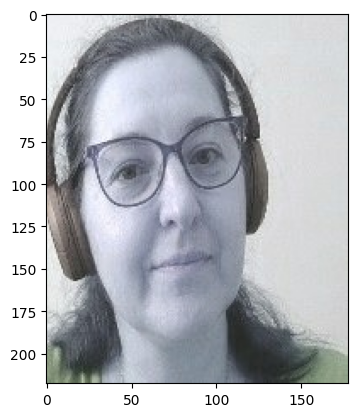

In [ ]:
plt.imshow(aug_img[3])

#### Aumentation of positives 👍 and anchors ⚓ 🖼

## Image preprocessing

### Preparing 3 datasets with 3000 elements



In [ ]:
positive = tf.data.Dataset.list_files(Pos_Path+'/*.jpg').take(2000)
negative = tf.data.Dataset.list_files(Neg_Path+'/*.jpg').take(2000)
anchor = tf.data.Dataset.list_files(Anc_Path+'/*.jpg').take(2000)

In [ ]:
dir = anchor.as_numpy_iterator()

In [ ]:
print(dir.next())

b'/content/drive/MyDrive/Face_recognition/Data/anchor/e97970e2-9a8c-11ee-82b2-9cf387c0de02.jpg'


In [ ]:
print(len(anchor))

2000


### - Scale and Resize

In [ ]:
def preprocess (img_path):

    # Read in image from file path
    byte_img = tf.io.read_file(img_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (105,105))
    # Scale image to be between 0 and 1
    img = img/255


    # Return image
    return img



In [ ]:
img = preprocess('/content/drive/MyDrive/Face_recognition/Data/anchor/065b7318-9a8d-11ee-82b2-9cf387c0de02.jpg')

In [ ]:
#checking preprocessing
img.numpy().max()

1.0

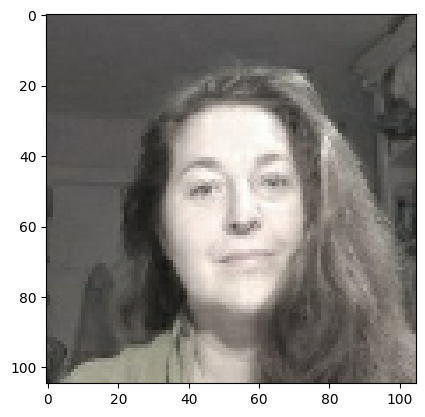

In [ ]:

plt.imshow(img)


## Dataset

### Create label dataset

In [ ]:
# assigning 1 and 0 to positive and negative examples with length of anchor (3000)
negative = tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
positive = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
data = negative.concatenate(positive)

In [ ]:
sample = data.as_numpy_iterator()


In [ ]:
sam = sample.next()
sam

(b'/content/drive/MyDrive/Face_recognition/Data/anchor/e44b93f2-9a8c-11ee-82b2-9cf387c0de02.jpg',
 b'/content/drive/MyDrive/Face_recognition/Data/Negative/151945.jpg',
 0.0)

### Train & Test separation

In [ ]:
# function to preprocess separately input image(anchor) and validation(negative, positive)
def preproc_input_val (input_img, val_img, label):
  return(preprocess(input_img), preprocess(val_img), label)

In [ ]:
#check with sample from dataset
res = preproc_input_val(*sam) # * unpack values from tuples

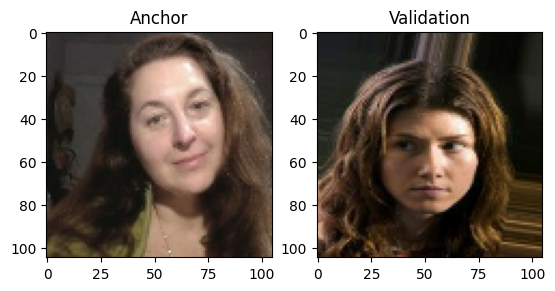

In [ ]:
#check th images
image_an = res[0]
image_val= res[1]

# Display the first image
plt.subplot(1, 2, 1)
plt.imshow(image_an )
plt.title('Anchor')

# Display the second image
plt.subplot(1, 2, 2)
plt.imshow(image_val)
plt.title('Validation')

plt.show()

In [ ]:
res[2]

0.0

In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
# Build dataloader pipeline
dataset = data.map(preproc_input_val) #X, y are assumed to be NumPy arrays or tensors. Each element of the dataset will be a tuple
dataset = dataset.cache() #adds caching to the dataset. Caching keeps the elements of the dataset in memory
dataset = dataset.shuffle(buffer_size=9000) #Shuffling is important during training to ensure that the model sees a different order of examples in each epoch.
dataset = dataset.batch(16) # number of lines(samples) in the set 16
dataset = dataset.prefetch(8) # helps bottlenecks


In [ ]:
len(dataset)

250

In [ ]:
train_data = dataset.take(int(len(dataset)*.8))
print(len(train_data))


200


In [ ]:
#val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*2))

#print(len(val))
print(len(test))

50


## Create model

### Embeding layer

In [ ]:
def create_embedding():
    inp = Input(shape=(105,105,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = create_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

### L1 Distance layer

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
L1=L1Dist()

###  Built Siamese network

In [ ]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(105,105,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

## Train NN


### Set up Loss and Optimizer


### Checkpoints

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Face_recognition/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Step Function

In [ ]:
test_batch = train_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
X=batch_1[:2]

In [ ]:
y=batch_1[2]


In [ ]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        y_pred = siamese_model(X, training=True)
        # Calculate loss
        loss= binary_cross_loss(y, y_pred)

    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

### Training Loop

In [ ]:
def model_train(data, EPOCHS, callbacks):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()
        a = BinaryAccuracy()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            y_pred = siamese_model.predict(batch[:2])
            r.update_state(batch[2], y_pred)
            p.update_state(batch[2], y_pred)
            a.update_state(batch[2], y_pred)
            progbar.update(idx+1)
        print("Loss:", loss.numpy(), 'Recall:', r.result().numpy(),'Precision:', p.result().numpy(), 'Accuracy:', a.result().numpy())

        # Save checkpoints
        if epoch % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
#Stop training when a monitored metric has stopped improving

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

### Train the model

In [ ]:
hist = model_train(train_data, EPOCHS=20, callbacks=[early_stopping])


 Epoch 1/20
200/200 [==============================] - 62s 310ms/step
Loss: 0.083487935 Recall: 0.9937772 Precision: 0.9937772 Accuracy: 0.99375

 Epoch 2/20
200/200 [==============================] - 64s 321ms/step
Loss: 0.071385235 Recall: 0.9938157 Precision: 0.9956629 Accuracy: 0.9946875

 Epoch 3/20
200/200 [==============================] - 67s 337ms/step
Loss: 0.035157155 Recall: 0.99316347 Precision: 0.9943995 Accuracy: 0.99375

 Epoch 4/20
200/200 [==============================] - 65s 324ms/step
Loss: 0.028594289 Recall: 0.99255586 Precision: 0.99564403 Accuracy: 0.9940625

 Epoch 5/20
200/200 [==============================] - 64s 318ms/step
Loss: 0.025266849 Recall: 0.9930774 Precision: 0.9943289 Accuracy: 0.99375

 Epoch 6/20
200/200 [==============================] - 67s 335ms/step
Loss: 0.025088126 Recall: 0.99373823 Precision: 0.9956085 Accuracy: 0.9946875

 Epoch 7/20
200/200 [==============================] - 65s 325ms/step
Loss: 0.083853886 Recall: 0.99250937 Precis

## Evaluation

### Make Predictions

In [ ]:

# Get a batch of test data
test_input, test_val, y_true = test.as_numpy_iterator().next()

In [ ]:
y_pred = (siamese_model.predict([test_input, test_val]) > 0.5).astype(int)

1/1 [==============================] - 0s 23ms/step


In [ ]:
y_pred

array([[1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]])

### Calculate metrics

In [ ]:
pre = Precision()
re = Recall()
ac = BinaryAccuracy()

In [ ]:
for test_input, test_val, y_true in test.as_numpy_iterator():
    y_pred = siamese_model.predict([test_input, test_val])
    ac.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    pre.update_state(y_true,y_pred)
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{ac.result()}')

1/1 [==============================] - 0s 21ms/step
Precision: 0.9895561337471008, Recall:0.9895561337471008, Accuracy:0.9900000095367432


In [ ]:
(y_pred> 0.5).astype(int)

array([[1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1]])

### Visualization

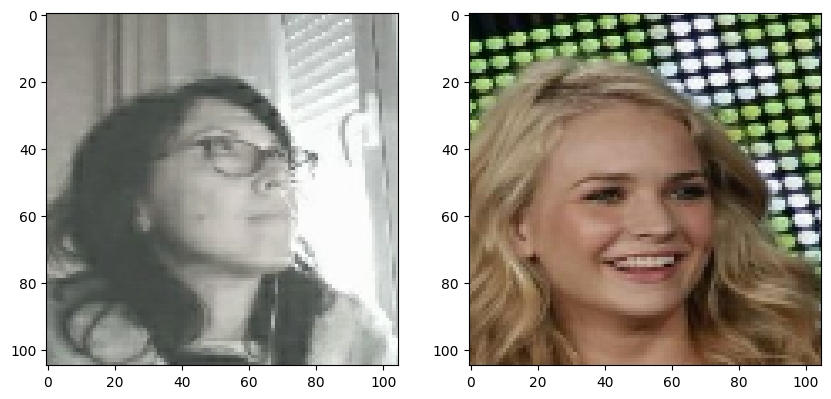

In [ ]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

## Save model

In [ ]:
# Save weights
siamese_model.save('/content/drive/MyDrive/Face_recognition/siamesemodelv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Reload model
siamese_model = tf.keras.models.load_model('/content/drive/MyDrive/Face_recognition/siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 134ms/step


array([[9.9959487e-01],
       [5.8909145e-04],
       [9.9996901e-01],
       [9.9907160e-01],
       [9.9199849e-01],
       [4.3202825e-05],
       [1.3905162e-03],
       [7.8017678e-07],
       [1.3288938e-05],
       [6.2486748e-07],
       [8.8958937e-01],
       [8.9466303e-06],
       [3.1751774e-06],
       [1.9590736e-05],
       [1.7250744e-05],
       [9.9726748e-01]], dtype=float32)

In [ ]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

## Real Time Test

### Verification Function

In [ ]:
# Rutas a las carpetas
application_data_path = "/content/drive/MyDrive/Face_recognition/application_data"
verification_images_path = os.path.join(application_data_path, "verification_images")
input_image_path = os.path.join(application_data_path, "input_image", "input_image.jpg")

In [ ]:
# Lista el contenido de 'verification_images'
verification_images = os.listdir(verification_images_path)

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')


'application_data/input_image/input_image.jpg'

In [ ]:
def verify(model, detection_threshold, verification_threshold):
  # Build results array
  results = []
  for image in os.listdir(os.path.join("application_data", "verification_images")):
      input_img = preprocess(os.path.join("application_data", "input_image", "input_image.jpg"))
      validation_img = preprocess(os.path.join("application_data", "verification_images", image))

  # Detection Threshold: Metric above which a prediction is considered positive
  detection = np.sum(np.array(results) > detection_threshold)

  # Verification Threshold: Proportion of positive predictions / total positive samples
  verification = detection / len(os.listdir(os.path.join("aplication_data", "verification_images")))
  verified = verification > verification_threshold

  return results, verified

### OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame =cap.read()
    frame = resized_frame[50:50 + 218, 120:120 + 178, :]
    cv2.imshow("Verification", frame)


    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
results